In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.optimize import curve_fit

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
c_folder="../../data/calibration/"
d_folder="../../data/runData/"
r_n=307

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

In [4]:
%%time
p,m,r=import_data(c_folder,d_folder, 305, is_it_pulsed=False)

CPU times: user 6.84 s, sys: 1.56 s, total: 8.4 s
Wall time: 8.4 s


In [5]:
%%time
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False) #this needs to be run as it's own cell

Number of events: 47351


Initial pedestal-based selection performed.
Events left: 46271


CPU times: user 922 ms, sys: 269 ms, total: 1.19 s
Wall time: 1.19 s


In [6]:
%%time 
# make cuts
r=first_layer_cut(r)
r=back_layer_cut(r,5)

Events with multiple hits in first layer removed.
Events left: 37232


Events with hits in the back 5 layers removed.
Events left: 36506


CPU times: user 71 ms, sys: 1.03 ms, total: 72 ms
Wall time: 71.3 ms


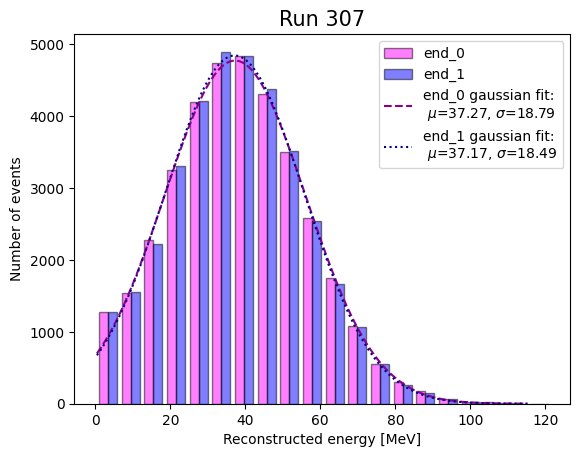

CPU times: user 551 ms, sys: 5.37 ms, total: 557 ms
Wall time: 570 ms


In [7]:
%%time
# fit gaussian to distribution of reconstructed energy
p0,p1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=False)

In [114]:
# %%time # make shower profiles
# make_shower_profiles(r, m, r_n, p_folder)

In [7]:
# %%time # make the pulse profile dataframe
# pulses=make_pulse_profiles(r)
# pulses.to_csv(d_folder+"/run_"+str(r_n)+"_pulse_problems.csv")